# Figure 4: Multiple Sequence Alignment Diversity vs Clustering Analysis

**Purpose:** Compare Hill's diversity of MSAs with MMseqs clustering patterns  
**Output:** Clustering analysis plots and diversity comparisons

## Setup and Configuration

In [ ]:
library(here)

In [ ]:
# Load required libraries and utility functions
suppressMessages(source(here("code/utils/utils.R")))

## MSA File Discovery and Processing Setup

In [ ]:
# Get list of FASTA files containing multiple sequence alignments
files <- list.files(here('data/example_pfam_families/'))
files <- files[grep("fasta", files)]

print(paste("Total FASTA files found:", length(files)))
print("First 10 MSA files:")
print(head(files, 10))

if (length(files) == 0) {
  stop("No FASTA files found in the current directory")
}

## MSA Diversity Analysis

Calculate Hill's diversity for each multiple sequence alignment

In [ ]:
# Initialize storage for MSA Hill's diversity results
msa_hill <- list()

print("Processing MSA files for diversity analysis...")
print("This may take several minutes depending on file sizes")

In [ ]:
# Process each MSA file
for (i in 1:length(files)) {
  if (i %% 10 == 0 || i == 1) print(paste("Processing file", i, "of", length(files), ":", files[i]))
  
  # Read multiple sequence alignment from FASTA format
  msa <- readBStringSet(paste(here('data/example_pfam_families/'), files[i], sep = ''))
  
  if (length(msa) > 0) {
    # Convert alignment to matrix format for column-wise analysis
    msa_mat <- as.matrix(msa)
    
    # Set Hill's diversity parameter (q=1 for exponential Shannon entropy)
    q <- 1
    
    # Calculate Hill's diversity for each alignment column
    column_diversities <- apply(msa_mat, 2, hill_diversity, q = q)
    
    # Store both column-wise and mean diversity values
    msa_hill[[files[i]]] <- list(all_hill = column_diversities,
                                mean_hill = mean(column_diversities))
  } else {
    print(paste("Warning: Empty MSA file:", files[i]))
  }
}

print("MSA diversity analysis complete!")
print(paste("Processed", length(msa_hill), "MSA files"))

## Data Cleaning and Normalization

In [6]:
# Remove file extensions from names for consistency
original_names <- names(msa_hill)[1:min(5, length(msa_hill))]
names(msa_hill) <- gsub(".fasta", "", names(msa_hill))
cleaned_names <- names(msa_hill)[1:min(5, length(msa_hill))]

print("Name cleaning example:")
print("Original names:")
print(original_names)
print("Cleaned names:")
print(cleaned_names)

# Show diversity statistics before normalization
raw_diversities <- unlist(lapply(msa_hill, function(x) x$mean_hill))
print("Raw Hill's diversity statistics:")
print(summary(raw_diversities))

[1] "Name cleaning example:"
[1] "Original names:"
[1] "PF00001.fasta" "PF00002.fasta" "PF00003.fasta" "PF00004.fasta"
[5] "PF00198.fasta"
[1] "Cleaned names:"
[1] "PF00001" "PF00002" "PF00003" "PF00004" "PF00198"
[1] "Raw Hill's diversity statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.125   2.573   2.759   3.392   5.541 


In [7]:
# Normalize diversity values (assuming 20 amino acids max)
norm_hill <- lapply(msa_hill, function(x) normalize_hill(x$mean_hill, 20))

print("Normalized Hill's diversity statistics:")
print(summary(unlist(norm_hill)))

# Remove last element (likely incomplete/problematic)
if (length(norm_hill) > 1) {
  print(paste("Removing last element:", names(norm_hill)[length(norm_hill)]))
  norm_hill <- norm_hill[-length(norm_hill)]
}

print(paste("Final MSA dataset size:", length(norm_hill), "families"))

[1] "Normalized Hill's diversity statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05923 0.08280 0.09258 0.12590 0.23899 
[1] "Removing last element: PF25158"
[1] "Final MSA dataset size: 218 families"


## MMseqs Clustering Analysis

Cluster sequences using MMseqs2 over a range of sequence similarities (from 0.1 to 0.9 by 0.1 increments)

In [ ]:
system('./code/utils/fig4_cluster_fasta_directory.sh -d data/example_pfam_families/ -o data/example_pfam_families/clustering_results/')

Load MMseqs2 results

In [ ]:
# Load MMseqs clustering results
res <- read.csv(here("data/example_pfam_families/clustering_results/clustering_summary.csv"),
               header = TRUE)

print(paste("Clustering data loaded:", nrow(res), "entries"))
print("Column names:")
print(colnames(res))
print("First few rows:")
print(head(res))

# Show unique families
print(paste("Number of protein families:", length(unique(res$family))))
print("Families represented:")
print(unique(res$family)[1:min(10, length(unique(res$family)))])

[1] "Clustering data loaded: 1980 entries"
[1] "Column names:"
[1] "family"          "seq_identity"    "num_clusters"    "total_sequences"
[1] "First few rows:"
   family seq_identity num_clusters total_sequences
1 PF00002          0.1        24229           27754
2 PF00001          0.8       112859          132344
3 PF00001          0.7       112634          132344
4 PF00001          0.6       112631          132344
5 PF00001          0.9       119787          132344
6 PF00001          0.5       112631          132344
[1] "Number of protein families: 219"
[1] "Families represented:"
 [1] "PF00002" "PF00001" "PF00003" "PF00004" "PF00198" "PF00207" "PF00244"
 [8] "PF00324" "PF00389" "PF00393"


## Clustering Data Processing

In [13]:
# Split results by protein family
res <- split(res, res$family)

print(paste("Data split into", length(res), "families"))

# Calculate clustering proportions for each family
for (i in 1:length(res)) {
  res[[i]]$prop <- res[[i]]$num_clusters / res[[i]]$total_sequences
}

print("Clustering proportions calculated")

# Show example proportions
if (length(res) > 0) {
  print("Example clustering proportions for first family:")
  print(res[[1]][c("seq_identity", "num_clusters", "total_sequences", "prop")])
}

[1] "Data split into 219 families"
[1] "Clustering proportions calculated"
[1] "Example clustering proportions for first family:"
   seq_identity num_clusters total_sequences      prop
2           0.8       112859          132344 0.8527701
3           0.7       112634          132344 0.8510699
4           0.6       112631          132344 0.8510473
5           0.9       119787          132344 0.9051185
6           0.5       112631          132344 0.8510473
7           0.4       112631          132344 0.8510473
8           0.3       112631          132344 0.8510473
9           0.2       112631          132344 0.8510473
10          0.1       112631          132344 0.8510473


In [14]:
# Remove last element for consistency
if (length(res) > 1) {
  print(paste("Removing last element:", names(res)[length(res)]))
  res <- res[-length(res)]
}

print(paste("Final clustering dataset size:", length(res), "families"))

# Show proportion statistics across all families
all_props <- unlist(lapply(res, function(x) x$prop))
print("Clustering proportion statistics across all families:")
print(summary(all_props))

[1] "Removing last element: PF25158"
[1] "Final clustering dataset size: 218 families"
[1] "Clustering proportion statistics across all families:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02156 0.44898 0.81491 0.68836 0.95966 1.00000 


## Cumulative Clustering Analysis

Calculate cumulative clustering proportions across sequence identities

In [15]:
# Calculate cumulative clustering proportions
props <- list()
for (i in 1:length(res)) {
  props[[i]] <- sort(res[[i]]$num_clusters)
}
props <- do.call(rbind, props)
props <- colSums(props)
props <- props / props[length(props)]

print("Cumulative clustering proportions:")
print(props)
print(paste("Range:", round(min(props), 3), "to", round(max(props), 3)))

[1] "Cumulative clustering proportions:"
[1] 0.8830419 0.8830508 0.8833843 0.8844400 0.8863294 0.8892366 0.8931429
[8] 0.9113617 1.0000000
[1] "Range: 0.883 to 1"


## Slope Analysis

Calculate slopes of clustering trends vs sequence identity

In [16]:
# Calculate slopes of clustering trends vs sequence identity
slopes <- lapply(res, function(x) {
  if (nrow(x) > 1 && var(x$seq_identity) > 0) {
    coef(lm(x$prop ~ x$seq_identity))[2]
  } else {
    NA
  }
})

# Remove NA values
slopes <- slopes[!is.na(slopes)]

print("Slope analysis results:")
print(paste("Number of families with valid slopes:", length(slopes)))
print("Slope statistics:")
print(summary(unlist(slopes)))

# Display sorted slopes
sorted_slopes <- sort(unlist(slopes))
print("Sorted slopes (first 10):")
print(head(sorted_slopes, 10))

[1] "Slope analysis results:"
[1] "Number of families with valid slopes: 218"
[1] "Slope statistics:"
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.02418 0.12262 0.21436 0.35316 0.92857 
[1] "Sorted slopes (first 10):"
PF06725.x$seq_identity PF02737.x$seq_identity PF09847.x$seq_identity 
         -2.405299e-16          -9.456544e-17          -8.326673e-17 
PF17837.x$seq_identity PF11330.x$seq_identity PF06983.x$seq_identity 
         -8.326673e-17          -5.551115e-17          -5.551115e-17 
PF21585.x$seq_identity PF21396.x$seq_identity PF12574.x$seq_identity 
         -2.775558e-17           5.551115e-17           6.245005e-17 
PF13906.x$seq_identity 
          1.096706e-16 


## Data Integration

Match MSA diversity data with clustering results

In [17]:
# Match MSA diversity data with clustering results
print("Matching datasets...")
print(paste("MSA families:", length(names(norm_hill))))
print(paste("Clustering families:", length(names(res))))

# Find common families
common_families <- intersect(names(norm_hill), names(res))
print(paste("Common families:", length(common_families)))

if (length(common_families) > 0) {
  print("First few common families:")
  print(head(common_families))
} else {
  print("Warning: No common families found between datasets")
}

[1] "Matching datasets..."
[1] "MSA families: 218"
[1] "Clustering families: 218"
[1] "Common families: 218"
[1] "First few common families:"
[1] "PF00001" "PF00002" "PF00003" "PF00004" "PF00198" "PF00207"


In [18]:
# Extract data for matching families
x <- res[match(names(norm_hill), names(res))]
x <- unlist(lapply(x, function(y) {
  if (!is.null(y) && nrow(y) >= 9) {
    y$prop[9]  # Extract proportion at 9th identity level
  } else {
    NA
  }
}))

z <- unlist(slopes[match(names(norm_hill), names(slopes))])
y <- unlist(norm_hill)

print("Extracted data summary:")
print(paste("Clustering proportions (x):", sum(!is.na(x)), "valid values"))
print(paste("Slopes (z):", sum(!is.na(z)), "valid values"))
print(paste("Hill diversities (y):", sum(!is.na(y)), "valid values"))

# Show complete cases
complete_cases <- sum(!is.na(x) & !is.na(z) & !is.na(y))
print(paste("Complete cases for analysis:", complete_cases))

[1] "Extracted data summary:"
[1] "Clustering proportions (x): 218 valid values"
[1] "Slopes (z): 218 valid values"
[1] "Hill diversities (y): 218 valid values"
[1] "Complete cases for analysis: 218"


## Plot 1: Overall Clustering Trends

[1] "Plot 1 created: Overall clustering trends"


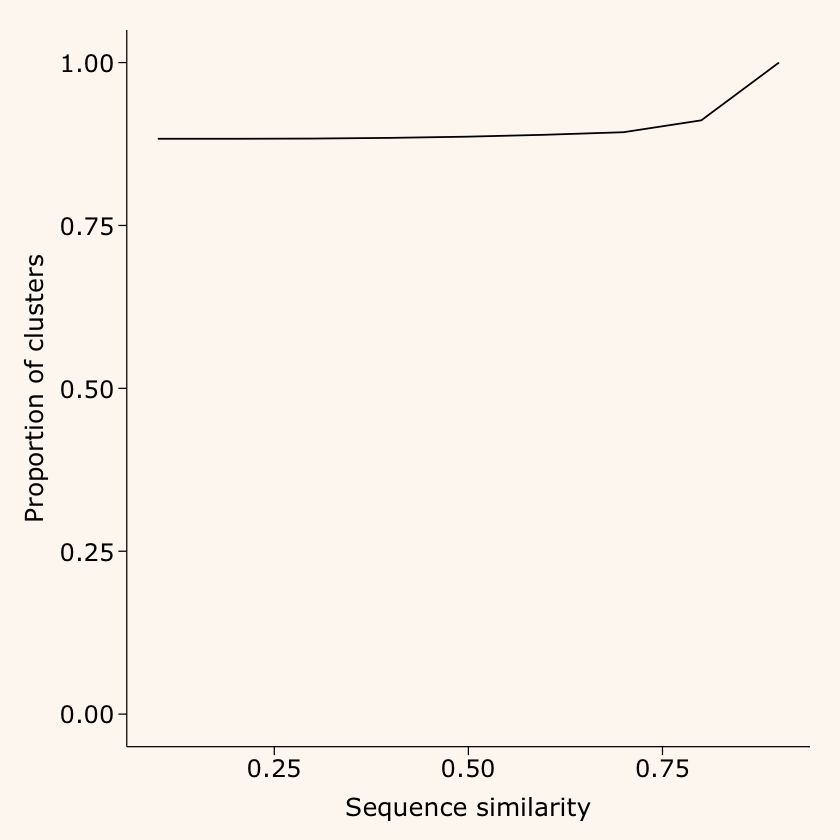

In [19]:
# Prepare data for cumulative clustering plot
df <- data.frame(sim = seq(0.1, 0.9, 0.1), props = props)

p1 <- ggplot(data = df,
            aes(x = sim, y = props)) +
  xlab("Sequence similarity") +
  ylab("Proportion of clusters") +
  geom_line() +
  theme(legend.position = "none") +
  ylim(c(0, 1)) +
  theme_arcadia()

print(p1)
print("Plot 1 created: Overall clustering trends")

## Plot 2: Family-specific Clustering Patterns

[1] "Family clustering data prepared: 2180 points across 218 families"
[1] "Plot 2 created: Family-specific clustering patterns"


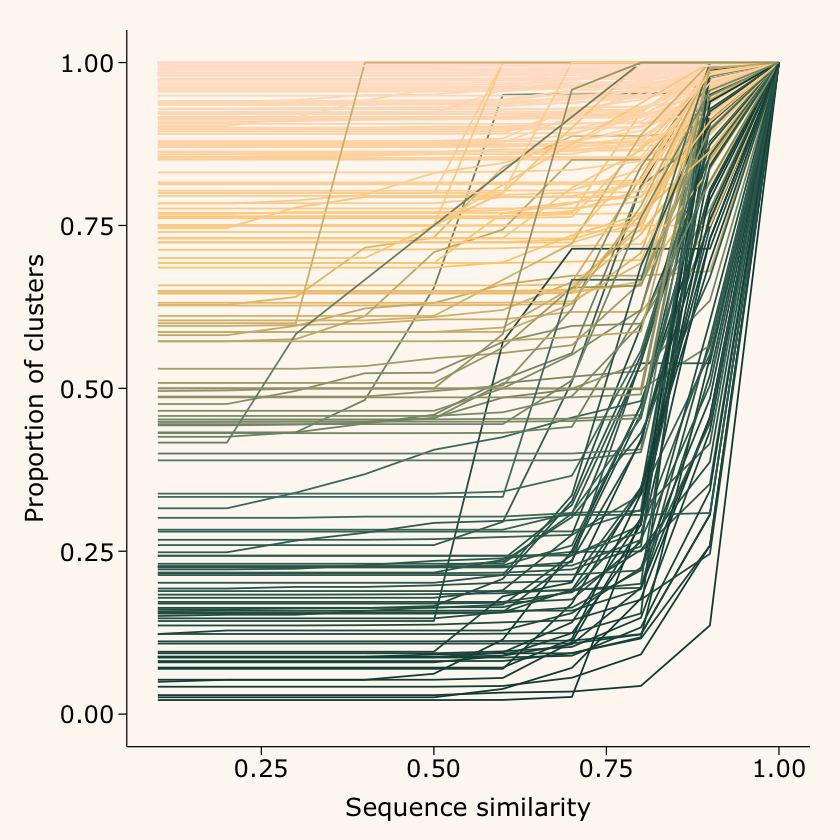

In [20]:
# Prepare data for individual family clustering curves
df <- data.frame(props = unlist(lapply(res, function(x) c(sort(x$prop), 1))),
                variable = rep(1:length(res), each = length(seq(0.1, 1, 0.1))))
df$sim <- rep(seq(0.1, 1, 0.1), length(res))
df$color <- rep(unlist(lapply(res, function(x) min(x$prop))),
               each = length(seq(0.1, 1, 0.1)))

print(paste("Family clustering data prepared:", nrow(df), "points across", length(res), "families"))

p2 <- ggplot(data = df,
            aes(x = sim,
                y = props,
                group = variable,
                color = color)) +
  scale_color_gradientn(colours = arcadia_gradient_palette("verde")$colors) +
  xlab("Sequence similarity") +
  ylab("Proportion of clusters") +
  geom_line(show.legend = FALSE) +
  theme(legend.position = "none") +
  ylim(c(0, 1)) +
  theme_arcadia()

print(p2)
print("Plot 2 created: Family-specific clustering patterns")

## Plot 3: Diversity vs Clustering Relationship

[1] "Correlation data prepared: 218 complete cases"


`geom_smooth()` using formula = 'y ~ x'


[1] "Plot 3 created: Diversity vs clustering relationship"
[1] "Correlation between slopes and Hill's diversity: 0.5555"


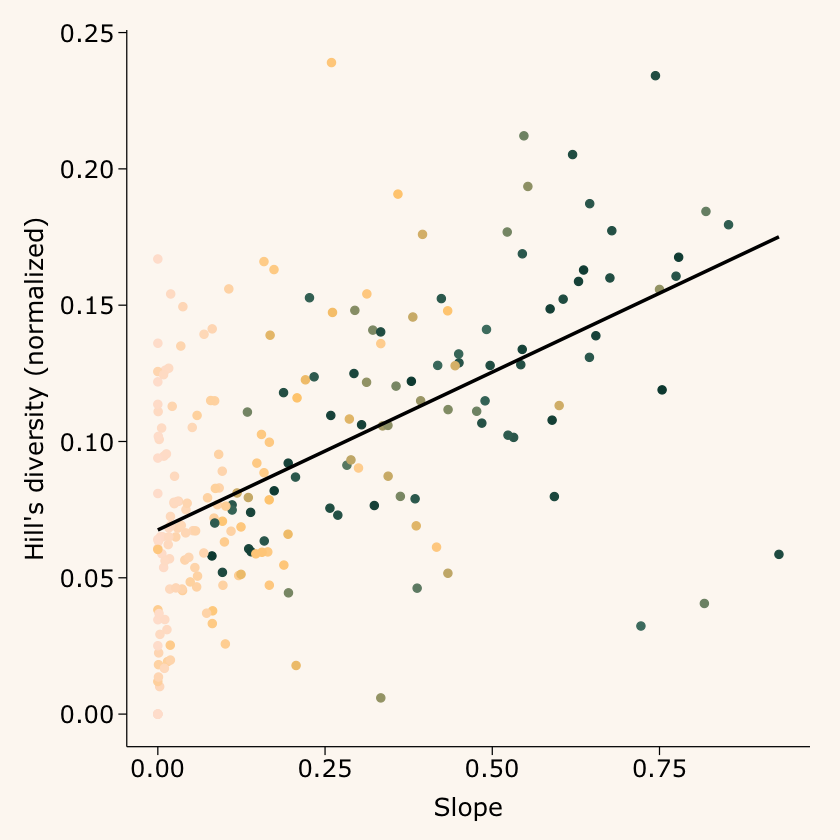

In [21]:
# Prepare data for slope vs Hill's diversity correlation
# Use matched data to ensure color values are available
color_values <- unlist(lapply(res[match(names(norm_hill), names(res))], function(x) {
  if (!is.null(x)) {
    min(x$prop)
  } else {
    NA
  }
}))

df <- data.frame(slopes = z,
                hill = y,
                color = color_values)

# Remove rows with missing data
df <- df[complete.cases(df), ]

print(paste("Correlation data prepared:", nrow(df), "complete cases"))

if (nrow(df) > 1) {
  p3 <- ggplot(data = df,
              aes(x = slopes,
                  y = hill,
                  color = color)) +
    scale_color_gradientn(colours = arcadia_gradient_palette("verde")$colors) +
    xlab("Slope") +
    ylab("Hill's diversity (normalized)") +
    geom_point(size = 2, show.legend = FALSE) +
    theme(legend.position = "none") +
    geom_smooth(method = "lm", se = FALSE, color = "black") +
    theme_arcadia()
  
  print(p3)
  print("Plot 3 created: Diversity vs clustering relationship")
  
  # Calculate correlation
  correlation <- cor(df$slopes, df$hill, use = "complete.obs")
  print(paste("Correlation between slopes and Hill's diversity:", round(correlation, 4)))
} else {
  print("Insufficient data for correlation plot")
}

## Combined Output Generation

`geom_smooth()` using formula = 'y ~ x'


[1] "Combined plots displayed"


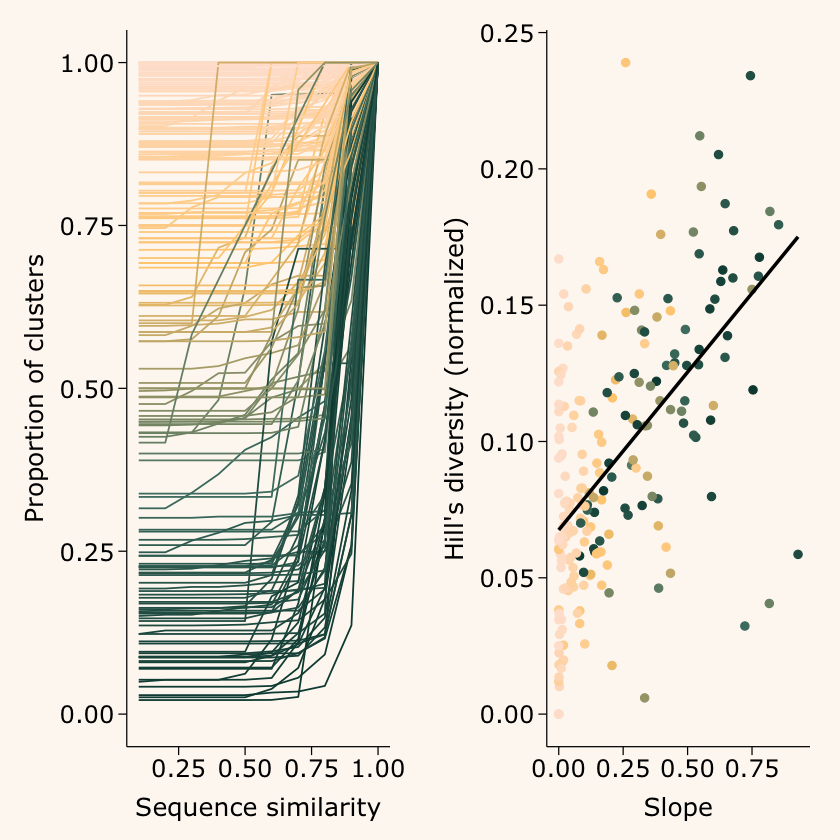

In [22]:
# Combine and display plots
if (exists("p2") && exists("p3")) {
  grid.arrange(p2, p3, nrow = 1)
  print("Combined plots displayed")
} else {
  print("Not all plots available for combination")
}

## Conclusion

This analysis:
1. Calculated Hill's diversity for multiple sequence alignments across protein families
2. Analyzed MMseqs clustering patterns at different sequence identity thresholds
3. Computed clustering trend slopes for each protein family
4. Visualized overall and family-specific clustering patterns
5. Examined the relationship between sequence diversity and clustering behavior

The results reveal how protein family diversity relates to clustering patterns, providing insights into the relationship between sequence conservation and structural/functional constraints across different protein families.